# ResNet-18 Emotion Recognition Model Training

This notebook implements a ResNet-18 model for emotion recognition with professional training pipeline and visualization.

## Features:
- ResNet-18 architecture with custom classifier head
- Advanced data augmentation
- Mixed precision training
- Professional visualization
- Model checkpointing and early stopping

**Author:** FC211033 Sahan  
**Date:** July 2025

## 1. Import Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms, models

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import time
import json
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

# Set style for professional plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA Memory: 4.0 GB


## 2. Configuration

In [7]:
CONFIG = {
    'data_path': '../../data/processed/FC211033_Sahan',
    'save_dir': './models',
    'image_size': 64,
    'batch_size': 32,
    'num_workers': 0,  # Set to 0 for Windows compatibility
    'epochs': 25,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'patience': 8,
    'num_classes': 5,
    'dropout_rate': 0.3,
    'label_smoothing': 0.1,
    'mixup_alpha': 0.2,
    'train_split': 0.8  # 80% for training, 20% for validation
}

# Create save directory
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# Print configuration
print("Configuration:")
print("-" * 40)
for key, value in CONFIG.items():
    print(f"{key:15}: {value}")

Configuration:
----------------------------------------
data_path      : ../../data/processed/FC211033_Sahan
save_dir       : ./models
image_size     : 64
batch_size     : 32
num_workers    : 0
epochs         : 25
learning_rate  : 0.001
weight_decay   : 0.0001
patience       : 8
num_classes    : 5
dropout_rate   : 0.3
label_smoothing: 0.1
mixup_alpha    : 0.2
train_split    : 0.8


## 3. Dataset Implementation

In [8]:
class EmotionDataset(Dataset):
    """Professional emotion dataset with advanced augmentation."""
    
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
        
        print(f"Dataset created with {len(self.data_list)} samples")
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        item = self.data_list[idx]
        
        # Load image
        image = cv2.imread(item['path'], cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise RuntimeError(f"Could not load image: {item['path']}")
            
        image = cv2.resize(image, (CONFIG['image_size'], CONFIG['image_size']))
        image = Image.fromarray(image).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, item['label']

def load_emotion_data(data_path):
    """Load all emotion data and create train/validation splits."""
    data_path = Path(data_path)
    
    # Define emotion classes - updated to match actual data structure
    emotions = ['angry', 'happy', 'neutral', 'sad', 'surprise']
    class_to_idx = {emotion: idx for idx, emotion in enumerate(emotions)}
    
    print(f"Loading data from: {data_path}")
    print(f"Expected emotions: {emotions}")
    
    all_data = []
    class_counts = {emotion: 0 for emotion in emotions}
    
    for emotion in emotions:
        emotion_path = data_path / emotion
        print(f"\nChecking: {emotion_path}")
        
        if emotion_path.exists():
            # Try different image extensions
            image_files = []
            for ext in ['*.png', '*.jpg', '*.jpeg']:
                image_files.extend(list(emotion_path.glob(ext)))
            
            print(f"  Found {len(image_files)} image files")
            
            for img_path in image_files:
                all_data.append({
                    'path': str(img_path),
                    'label': class_to_idx[emotion],
                    'emotion': emotion
                })
                class_counts[emotion] += 1
        else:
            print(f"  ❌ Directory not found: {emotion_path}")
    
    print(f"\nTotal samples loaded: {len(all_data)}")
    print("Class distribution:")
    for emotion, count in class_counts.items():
        if len(all_data) > 0:
            percentage = (count / len(all_data)) * 100
            print(f"  {emotion:8}: {count:4d} ({percentage:5.1f}%)")
    
    if len(all_data) == 0:
        raise RuntimeError("No data found! Please check the data path and structure.")
    
    # Shuffle data
    np.random.shuffle(all_data)
    
    # Split into train and validation
    split_idx = int(len(all_data) * CONFIG['train_split'])
    train_data = all_data[:split_idx]
    val_data = all_data[split_idx:]
    
    print(f"\nData split:")
    print(f"  Training:   {len(train_data)} samples ({len(train_data)/len(all_data)*100:.1f}%)")
    print(f"  Validation: {len(val_data)} samples ({len(val_data)/len(all_data)*100:.1f}%)")
    
    return train_data, val_data, emotions, class_to_idx

# Load the data
train_data, val_data, emotion_classes, class_to_idx = load_emotion_data(CONFIG['data_path'])

# Update config with actual number of classes
CONFIG['num_classes'] = len(emotion_classes)
print(f"\nUpdated num_classes to: {CONFIG['num_classes']}")
print(f"Emotion classes: {emotion_classes}")

Loading data from: ..\..\data\processed\FC211033_Sahan
Expected emotions: ['angry', 'happy', 'neutral', 'sad', 'surprise']

Checking: ..\..\data\processed\FC211033_Sahan\angry
  Found 3983 image files

Checking: ..\..\data\processed\FC211033_Sahan\happy
  Found 7210 image files

Checking: ..\..\data\processed\FC211033_Sahan\neutral
  Found 4959 image files

Checking: ..\..\data\processed\FC211033_Sahan\sad
  Found 4826 image files

Checking: ..\..\data\processed\FC211033_Sahan\surprise
  Found 3165 image files

Total samples loaded: 24143
Class distribution:
  angry   : 3983 ( 16.5%)
  happy   : 7210 ( 29.9%)
  neutral : 4959 ( 20.5%)
  sad     : 4826 ( 20.0%)
  surprise: 3165 ( 13.1%)

Data split:
  Training:   19314 samples (80.0%)
  Validation: 4829 samples (20.0%)

Updated num_classes to: 5
Emotion classes: ['angry', 'happy', 'neutral', 'sad', 'surprise']


## 4. Data Transforms and Loaders

In [10]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets using the loaded data
print("Creating datasets...")
train_dataset = EmotionDataset(train_data, train_transform)
val_dataset = EmotionDataset(val_data, val_transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n Data loaders created successfully:")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples:   {len(val_dataset)}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Batch size:    {CONFIG['batch_size']}")

# Test loading a sample batch
try:
    sample_batch = next(iter(train_loader))
    print(f"\n Sample batch loaded successfully:")
    print(f"  Images shape: {sample_batch[0].shape}")
    print(f"  Labels shape: {sample_batch[1].shape}")
    print(f"  Image range: [{sample_batch[0].min():.3f}, {sample_batch[0].max():.3f}]")
    print(f"  Label range: [{sample_batch[1].min()}, {sample_batch[1].max()}]")
except Exception as e:
    print(f" Error loading sample batch: {e}")

Creating datasets...
Dataset created with 19314 samples
Dataset created with 4829 samples

 Data loaders created successfully:
  Train samples: 19314
  Val samples:   4829
  Train batches: 604
  Val batches:   151
  Batch size:    32

 Sample batch loaded successfully:
  Images shape: torch.Size([32, 3, 64, 64])
  Labels shape: torch.Size([32])
  Image range: [-2.118, 2.640]
  Label range: [0, 4]


## 5. Model Architecture

In [11]:
class EmotionResNet(nn.Module):
    """ResNet-18 based emotion recognition model."""
    
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super(EmotionResNet, self).__init__()
        
        # Load pretrained ResNet-18
        self.backbone = models.resnet18(pretrained=True)
        
        # Freeze early layers for transfer learning
        for param in list(self.backbone.parameters())[:-20]:
            param.requires_grad = False
        
        # Get feature size
        feature_size = self.backbone.fc.in_features
        
        # Replace classifier head
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(feature_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Create model
model = EmotionResNet(
    num_classes=CONFIG['num_classes'], 
    dropout_rate=CONFIG['dropout_rate']
).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print("-" * 40)
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size:           {total_params * 4 / 1024**2:.1f} MB")

Model Architecture:
----------------------------------------
Total parameters:     11,309,637
Trainable parameters: 9,117,189
Model size:           43.1 MB


## 6. Training Setup

In [12]:
# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])

# Optimizer with weight decay
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

# Mixed precision scaler
scaler = GradScaler()

print("Training components initialized:")
print("-" * 40)
print(f"Criterion:     CrossEntropyLoss (label_smoothing={CONFIG['label_smoothing']})")
print(f"Optimizer:     AdamW (lr={CONFIG['learning_rate']}, wd={CONFIG['weight_decay']})")
print(f"Scheduler:     CosineAnnealingWarmRestarts")
print(f"Mixed Precision: Enabled")

Training components initialized:
----------------------------------------
Criterion:     CrossEntropyLoss (label_smoothing=0.1)
Optimizer:     AdamW (lr=0.001, wd=0.0001)
Scheduler:     CosineAnnealingWarmRestarts
Mixed Precision: Enabled


## 7. Training Functions

In [13]:
def mixup_data(x, y, alpha=0.2):
    """Apply mixup data augmentation."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute mixup loss."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_epoch(model, loader, criterion, optimizer, scaler, epoch):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc=f'Epoch {epoch:2d}')
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        # Apply mixup with probability
        if np.random.random() < 0.5:
            data, target_a, target_b, lam = mixup_data(data, target, CONFIG['mixup_alpha'])
            
            optimizer.zero_grad()
            
            with autocast():
                output = model(data)
                loss = mixup_criterion(criterion, output, target_a, target_b, lam)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Calculate accuracy for mixup
            _, predicted = output.max(1)
            total += target.size(0)
            correct += (lam * predicted.eq(target_a).sum().float() + 
                       (1 - lam) * predicted.eq(target_b).sum().float()).item()
        else:
            optimizer.zero_grad()
            
            with autocast():
                output = model(data)
                loss = criterion(output, target)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Calculate accuracy
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        
        running_loss += loss.item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    """Validate model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            with autocast():
                output = model(data)
                loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy

print("Training functions defined")

Training functions defined


## 8. Training Loop

In [14]:
def train_model():
    """Complete training loop with early stopping."""
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    
    print("Starting training...")
    print("=" * 60)
    
    start_time = time.time()
    
    for epoch in range(1, CONFIG['epochs'] + 1):
        epoch_start = time.time()
        
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, scaler, epoch
        )
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        # Update scheduler
        scheduler.step()
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])
        
        # Print epoch summary
        epoch_time = time.time() - epoch_start
        print(f"\nEpoch {epoch:2d} Summary:")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
        print(f"  LR:    {optimizer.param_groups[0]['lr']:.2e}")
        print(f"  Time:  {epoch_time:.1f}s")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_acc': val_acc,
                'config': CONFIG,
                'history': history
            }, os.path.join(CONFIG['save_dir'], 'best_resnet_model.pth'))
            
            print(f"  >> New best validation accuracy: {best_val_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"  >> Patience: {patience_counter}/{CONFIG['patience']}")
        
        # Early stopping
        if patience_counter >= CONFIG['patience']:
            print(f"\nEarly stopping triggered after {epoch} epochs")
            break
        
        print("-" * 60)
    
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/60:.1f} minutes")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    
    return history, best_val_acc

# Start training
training_history, best_accuracy = train_model()

Starting training...


Epoch  1: 100%|██████████| 604/604 [00:45<00:00, 13.37it/s, Loss=1.4401, Acc=42.83%]




Epoch  1 Summary:
  Train: Loss=1.4401, Acc=42.83%
  Val:   Loss=1.3013, Acc=51.98%
  LR:    9.76e-04
  Time:  50.6s
  >> New best validation accuracy: 51.98%
------------------------------------------------------------


Epoch  2: 100%|██████████| 604/604 [00:45<00:00, 13.32it/s, Loss=1.3296, Acc=49.79%]




Epoch  2 Summary:
  Train: Loss=1.3296, Acc=49.79%
  Val:   Loss=1.2147, Acc=56.22%
  LR:    9.05e-04
  Time:  51.3s
  >> New best validation accuracy: 56.22%
------------------------------------------------------------


Epoch  3: 100%|██████████| 604/604 [00:44<00:00, 13.46it/s, Loss=1.2929, Acc=51.87%]




Epoch  3 Summary:
  Train: Loss=1.2929, Acc=51.87%
  Val:   Loss=1.2025, Acc=56.95%
  LR:    7.94e-04
  Time:  50.6s
  >> New best validation accuracy: 56.95%
------------------------------------------------------------


Epoch  4: 100%|██████████| 604/604 [00:43<00:00, 14.02it/s, Loss=1.2729, Acc=53.44%]




Epoch  4 Summary:
  Train: Loss=1.2729, Acc=53.44%
  Val:   Loss=1.1839, Acc=57.84%
  LR:    6.55e-04
  Time:  49.2s
  >> New best validation accuracy: 57.84%
------------------------------------------------------------


Epoch  5: 100%|██████████| 604/604 [00:42<00:00, 14.29it/s, Loss=1.2452, Acc=54.66%]




Epoch  5 Summary:
  Train: Loss=1.2452, Acc=54.66%
  Val:   Loss=1.1650, Acc=58.73%
  LR:    5.01e-04
  Time:  48.2s
  >> New best validation accuracy: 58.73%
------------------------------------------------------------


Epoch  6: 100%|██████████| 604/604 [00:41<00:00, 14.53it/s, Loss=1.2423, Acc=54.86%]




Epoch  6 Summary:
  Train: Loss=1.2423, Acc=54.86%
  Val:   Loss=1.1296, Acc=60.80%
  LR:    3.46e-04
  Time:  47.0s
  >> New best validation accuracy: 60.80%
------------------------------------------------------------


Epoch  7: 100%|██████████| 604/604 [00:45<00:00, 13.33it/s, Loss=1.2011, Acc=57.18%]




Epoch  7 Summary:
  Train: Loss=1.2011, Acc=57.18%
  Val:   Loss=1.1198, Acc=61.07%
  LR:    2.07e-04
  Time:  51.7s
  >> New best validation accuracy: 61.07%
------------------------------------------------------------


Epoch  8: 100%|██████████| 604/604 [00:43<00:00, 13.80it/s, Loss=1.1917, Acc=58.44%]




Epoch  8 Summary:
  Train: Loss=1.1917, Acc=58.44%
  Val:   Loss=1.1125, Acc=61.94%
  LR:    9.64e-05
  Time:  50.4s
  >> New best validation accuracy: 61.94%
------------------------------------------------------------
  >> New best validation accuracy: 61.94%
------------------------------------------------------------


Epoch  9: 100%|██████████| 604/604 [00:43<00:00, 13.93it/s, Loss=1.1670, Acc=59.52%]




Epoch  9 Summary:
  Train: Loss=1.1670, Acc=59.52%
  Val:   Loss=1.1082, Acc=62.12%
  LR:    2.54e-05
  Time:  49.4s
  >> New best validation accuracy: 62.12%
------------------------------------------------------------


Epoch 10: 100%|██████████| 604/604 [00:40<00:00, 14.80it/s, Loss=1.1650, Acc=59.27%]




Epoch 10 Summary:
  Train: Loss=1.1650, Acc=59.27%
  Val:   Loss=1.1063, Acc=61.94%
  LR:    1.00e-03
  Time:  46.5s
  >> Patience: 1/8
------------------------------------------------------------


Epoch 11: 100%|██████████| 604/604 [00:40<00:00, 14.76it/s, Loss=1.2341, Acc=55.52%]




Epoch 11 Summary:
  Train: Loss=1.2341, Acc=55.52%
  Val:   Loss=1.1403, Acc=60.36%
  LR:    9.94e-04
  Time:  46.4s
  >> Patience: 2/8
------------------------------------------------------------


Epoch 12: 100%|██████████| 604/604 [00:41<00:00, 14.68it/s, Loss=1.2272, Acc=56.16%]




Epoch 12 Summary:
  Train: Loss=1.2272, Acc=56.16%
  Val:   Loss=1.1375, Acc=61.38%
  LR:    9.76e-04
  Time:  46.8s
  >> Patience: 3/8
------------------------------------------------------------


Epoch 13: 100%|██████████| 604/604 [00:40<00:00, 15.00it/s, Loss=1.2165, Acc=56.59%]




Epoch 13 Summary:
  Train: Loss=1.2165, Acc=56.59%
  Val:   Loss=1.1306, Acc=61.15%
  LR:    9.46e-04
  Time:  45.9s
  >> Patience: 4/8
------------------------------------------------------------


Epoch 14: 100%|██████████| 604/604 [00:41<00:00, 14.57it/s, Loss=1.2068, Acc=57.38%]




Epoch 14 Summary:
  Train: Loss=1.2068, Acc=57.38%
  Val:   Loss=1.1320, Acc=61.46%
  LR:    9.05e-04
  Time:  47.1s
  >> Patience: 5/8
------------------------------------------------------------


Epoch 15: 100%|██████████| 604/604 [00:42<00:00, 14.38it/s, Loss=1.2012, Acc=57.65%]




Epoch 15 Summary:
  Train: Loss=1.2012, Acc=57.65%
  Val:   Loss=1.1219, Acc=61.63%
  LR:    8.54e-04
  Time:  47.6s
  >> Patience: 6/8
------------------------------------------------------------


Epoch 16: 100%|██████████| 604/604 [00:40<00:00, 14.90it/s, Loss=1.1917, Acc=58.51%]




Epoch 16 Summary:
  Train: Loss=1.1917, Acc=58.51%
  Val:   Loss=1.1036, Acc=62.29%
  LR:    7.94e-04
  Time:  45.9s
  >> New best validation accuracy: 62.29%
------------------------------------------------------------


Epoch 17: 100%|██████████| 604/604 [00:42<00:00, 14.20it/s, Loss=1.1748, Acc=59.04%]




Epoch 17 Summary:
  Train: Loss=1.1748, Acc=59.04%
  Val:   Loss=1.1233, Acc=61.15%
  LR:    7.27e-04
  Time:  48.6s
  >> Patience: 1/8
------------------------------------------------------------


Epoch 18: 100%|██████████| 604/604 [00:41<00:00, 14.50it/s, Loss=1.1630, Acc=59.79%]




Epoch 18 Summary:
  Train: Loss=1.1630, Acc=59.79%
  Val:   Loss=1.1008, Acc=63.06%
  LR:    6.55e-04
  Time:  48.1s
  >> New best validation accuracy: 63.06%
------------------------------------------------------------


Epoch 19: 100%|██████████| 604/604 [00:42<00:00, 14.12it/s, Loss=1.1457, Acc=60.74%]




Epoch 19 Summary:
  Train: Loss=1.1457, Acc=60.74%
  Val:   Loss=1.1079, Acc=62.35%
  LR:    5.79e-04
  Time:  48.2s
  >> Patience: 1/8
------------------------------------------------------------


Epoch 20: 100%|██████████| 604/604 [00:40<00:00, 14.81it/s, Loss=1.1556, Acc=60.66%]




Epoch 20 Summary:
  Train: Loss=1.1556, Acc=60.66%
  Val:   Loss=1.0896, Acc=63.76%
  LR:    5.01e-04
  Time:  46.7s
  >> New best validation accuracy: 63.76%
------------------------------------------------------------


Epoch 21: 100%|██████████| 604/604 [00:41<00:00, 14.69it/s, Loss=1.1421, Acc=61.32%]




Epoch 21 Summary:
  Train: Loss=1.1421, Acc=61.32%
  Val:   Loss=1.0954, Acc=63.18%
  LR:    4.22e-04
  Time:  46.7s
  >> Patience: 1/8
------------------------------------------------------------


Epoch 22: 100%|██████████| 604/604 [00:40<00:00, 14.79it/s, Loss=1.1196, Acc=62.63%]




Epoch 22 Summary:
  Train: Loss=1.1196, Acc=62.63%
  Val:   Loss=1.0881, Acc=63.43%
  LR:    3.46e-04
  Time:  46.5s
  >> Patience: 2/8
------------------------------------------------------------


Epoch 23: 100%|██████████| 604/604 [00:40<00:00, 14.87it/s, Loss=1.1115, Acc=63.39%]




Epoch 23 Summary:
  Train: Loss=1.1115, Acc=63.39%
  Val:   Loss=1.0929, Acc=63.80%
  LR:    2.74e-04
  Time:  46.0s
  >> New best validation accuracy: 63.80%
------------------------------------------------------------


Epoch 24: 100%|██████████| 604/604 [00:40<00:00, 14.85it/s, Loss=1.1020, Acc=63.48%]




Epoch 24 Summary:
  Train: Loss=1.1020, Acc=63.48%
  Val:   Loss=1.0812, Acc=63.74%
  LR:    2.07e-04
  Time:  46.5s
  >> Patience: 1/8
------------------------------------------------------------


Epoch 25: 100%|██████████| 604/604 [00:40<00:00, 14.85it/s, Loss=1.0826, Acc=64.64%]




Epoch 25 Summary:
  Train: Loss=1.0826, Acc=64.64%
  Val:   Loss=1.0833, Acc=63.99%
  LR:    1.47e-04
  Time:  46.5s
  >> New best validation accuracy: 63.99%
------------------------------------------------------------

Training completed in 20.0 minutes
Best validation accuracy: 63.99%


## 9. Professional Visualization

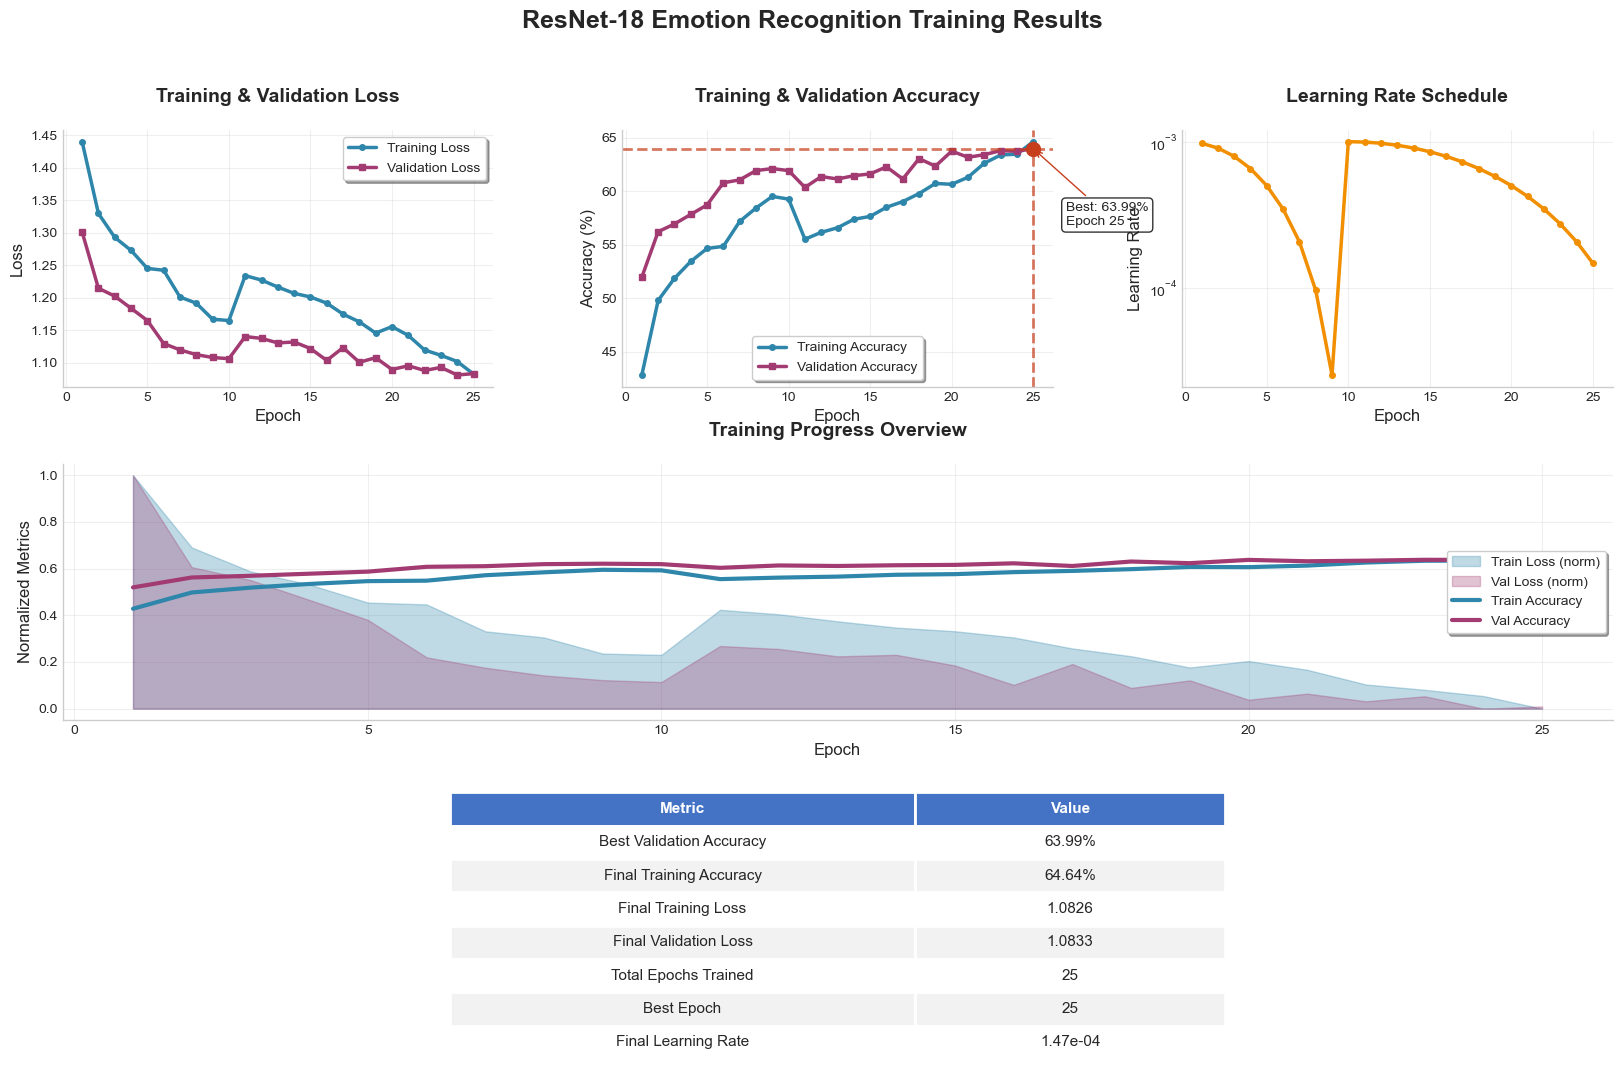

<Figure size 640x480 with 0 Axes>

In [15]:
def create_training_plots(history, best_acc):
    """Create professional training visualization."""
    
    # Set up the figure
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Color palette
    colors = {
        'train': '#2E86AB',
        'val': '#A23B72',
        'lr': '#F18F01',
        'best': '#C73E1D'
    }
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 1. Loss curves
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(epochs, history['train_loss'], color=colors['train'], 
             linewidth=2.5, label='Training Loss', marker='o', markersize=4)
    ax1.plot(epochs, history['val_loss'], color=colors['val'], 
             linewidth=2.5, label='Validation Loss', marker='s', markersize=4)
    ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # 2. Accuracy curves
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(epochs, history['train_acc'], color=colors['train'], 
             linewidth=2.5, label='Training Accuracy', marker='o', markersize=4)
    ax2.plot(epochs, history['val_acc'], color=colors['val'], 
             linewidth=2.5, label='Validation Accuracy', marker='s', markersize=4)
    
    # Highlight best accuracy
    best_epoch = np.argmax(history['val_acc']) + 1
    ax2.axvline(x=best_epoch, color=colors['best'], linestyle='--', alpha=0.7, linewidth=2)
    ax2.axhline(y=best_acc, color=colors['best'], linestyle='--', alpha=0.7, linewidth=2)
    ax2.scatter([best_epoch], [best_acc], color=colors['best'], s=100, zorder=5)
    ax2.annotate(f'Best: {best_acc:.2f}%\nEpoch {best_epoch}', 
                xy=(best_epoch, best_acc), xytext=(best_epoch + 2, best_acc - 5),
                fontsize=10, ha='left', va='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color=colors['best']))
    
    ax2.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend(frameon=True, fancybox=True, shadow=True)
    ax2.grid(True, alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # 3. Learning rate schedule
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(epochs, history['learning_rates'], color=colors['lr'], 
             linewidth=2.5, marker='o', markersize=4)
    ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Learning Rate', fontsize=12)
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # 4. Training progress comparison
    ax4 = fig.add_subplot(gs[1, :])
    
    # Normalize metrics for comparison
    train_loss_norm = (np.array(history['train_loss']) - np.min(history['train_loss'])) / (np.max(history['train_loss']) - np.min(history['train_loss']))
    val_loss_norm = (np.array(history['val_loss']) - np.min(history['val_loss'])) / (np.max(history['val_loss']) - np.min(history['val_loss']))
    train_acc_norm = np.array(history['train_acc']) / 100
    val_acc_norm = np.array(history['val_acc']) / 100
    
    ax4.fill_between(epochs, 0, train_loss_norm, alpha=0.3, color=colors['train'], label='Train Loss (norm)')
    ax4.fill_between(epochs, 0, val_loss_norm, alpha=0.3, color=colors['val'], label='Val Loss (norm)')
    ax4.plot(epochs, train_acc_norm, color=colors['train'], linewidth=3, label='Train Accuracy')
    ax4.plot(epochs, val_acc_norm, color=colors['val'], linewidth=3, label='Val Accuracy')
    
    ax4.set_title('Training Progress Overview', fontsize=14, fontweight='bold', pad=20)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Normalized Metrics', fontsize=12)
    ax4.legend(loc='center right', frameon=True, fancybox=True, shadow=True)
    ax4.grid(True, alpha=0.3)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    
    # 5. Training statistics
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('off')
    
    # Create statistics table
    stats_data = [
        ['Metric', 'Value'],
        ['Best Validation Accuracy', f'{best_acc:.2f}%'],
        ['Final Training Accuracy', f'{history["train_acc"][-1]:.2f}%'],
        ['Final Training Loss', f'{history["train_loss"][-1]:.4f}'],
        ['Final Validation Loss', f'{history["val_loss"][-1]:.4f}'],
        ['Total Epochs Trained', f'{len(epochs)}'],
        ['Best Epoch', f'{best_epoch}'],
        ['Final Learning Rate', f'{history["learning_rates"][-1]:.2e}']
    ]
    
    table = ax5.table(cellText=stats_data[1:], colLabels=stats_data[0],
                     cellLoc='center', loc='center',
                     colWidths=[0.3, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(stats_data)):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#4472C4')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#F2F2F2' if i % 2 == 0 else 'white')
            cell.set_edgecolor('white')
            cell.set_linewidth(2)
    
    # Add title
    fig.suptitle('ResNet-18 Emotion Recognition Training Results', 
                fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    plt.savefig(os.path.join(CONFIG['save_dir'], 'training_results.png'), 
                dpi=300, bbox_inches='tight', facecolor='white')

# Create visualization
create_training_plots(training_history, best_accuracy)

## 10. Model Evaluation and Summary

In [16]:
# Load best model for evaluation
checkpoint = torch.load(os.path.join(CONFIG['save_dir'], 'best_resnet_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])

# Final evaluation
final_val_loss, final_val_acc = validate(model, val_loader, criterion)

print("\n" + "=" * 60)
print("TRAINING COMPLETED SUCCESSFULLY")
print("=" * 60)
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")
print(f"Final Training Accuracy: {training_history['train_acc'][-1]:.2f}%")
print(f"Final Training Loss: {training_history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {training_history['val_loss'][-1]:.4f}")
print(f"Total Epochs: {len(training_history['train_loss'])}")

# GPU Memory usage
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated() / 1024**3
    cached = torch.cuda.memory_reserved() / 1024**3
    print(f"\nGPU Memory Usage:")
    print(f"  Allocated: {allocated:.2f} GB")
    print(f"  Cached: {cached:.2f} GB")

print(f"\nModel saved to: {CONFIG['save_dir']}/best_resnet_model.pth")
print(f"Visualization saved to: {CONFIG['save_dir']}/training_results.png")




TRAINING COMPLETED SUCCESSFULLY
Best Validation Accuracy: 63.99%
Final Training Accuracy: 64.64%
Final Training Loss: 1.0826
Final Validation Loss: 1.0833
Total Epochs: 25

GPU Memory Usage:
  Allocated: 0.27 GB
  Cached: 0.33 GB

Model saved to: ./models/best_resnet_model.pth
Visualization saved to: ./models/training_results.png
